## Projeto : Análise de notas de estudantes 
Nesse projeto vamos analisar como diversas variáveis do dia a dia dos estudantes pode influenciar numa nota de prova.
Assim, os professores poderão identificar padrões e prever antecipadamente se o estudante precisa de uma intervenção ou não.

### Carregamento dos pacotes 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import root_mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

### Carregamento e pré-processamento dos dados

In [2]:
df_dados = pd.read_csv(r'dados/Exam_Score_Prediction.csv', sep = ',', encoding = 'utf-8')

In [3]:
df_dados.head()

,student_id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,1,17,male,diploma,2.78,92.9,yes,7.4,poor,coaching,low,hard,58.9
1,2,23,other,bca,3.37,64.8,yes,4.6,average,online videos,medium,moderate,54.8
2,3,22,male,b.sc,7.88,76.8,yes,8.5,poor,coaching,high,moderate,90.3
3,4,20,other,diploma,0.67,48.4,yes,5.8,average,online videos,low,moderate,29.7
4,5,20,female,diploma,0.89,71.6,yes,9.8,poor,coaching,low,moderate,43.7


In [4]:
df_dados.shape

(20000, 13)

In [5]:
# vamos verificar os tipos de dados
df_dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   student_id        20000 non-null  int64  
 1   age               20000 non-null  int64  
 2   gender            20000 non-null  object 
 3   course            20000 non-null  object 
 4   study_hours       20000 non-null  float64
 5   class_attendance  20000 non-null  float64
 6   internet_access   20000 non-null  object 
 7   sleep_hours       20000 non-null  float64
 8   sleep_quality     20000 non-null  object 
 9   study_method      20000 non-null  object 
 10  facility_rating   20000 non-null  object 
 11  exam_difficulty   20000 non-null  object 
 12  exam_score        20000 non-null  float64
dtypes: float64(4), int64(2), object(7)
memory usage: 2.0+ MB


* Nesse dataset não existe nenhum dado nulo.

* Além disso, os tipos de dados atribuídos às colunas também estão corretos.

Agora, irei retirar a coluna student_id porque ela é apenas um identificador de aluno,
não tendo influência alguma sobre o resultado da nota do estudante.

In [6]:
df_dados.columns

Index(['student_id', 'age', 'gender', 'course', 'study_hours',
       'class_attendance', 'internet_access', 'sleep_hours', 'sleep_quality',
       'study_method', 'facility_rating', 'exam_difficulty', 'exam_score'],
      dtype='object')

In [7]:
atributos_deletados = ['student_id']

In [8]:
atributos = [col for col in df_dados.columns if col not in atributos_deletados]

In [9]:
atributos

['age',
 'gender',
 'course',
 'study_hours',
 'class_attendance',
 'internet_access',
 'sleep_hours',
 'sleep_quality',
 'study_method',
 'facility_rating',
 'exam_difficulty',
 'exam_score']

### Análise exploratória dos dados

1 - Entendendo o comportamento das variáveis


In [10]:
# descrição das variáveis numérica
df_dados[atributos].describe()

,age,study_hours,class_attendance,sleep_hours,exam_score
count,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000
mean,20.473300,4.007604,70.017365,7.00856,62.513225
std,2.284458,2.308313,17.282262,1.73209,18.908491
min,17.000000,0.080000,40.600000,4.10000,19.599000
25%,18.000000,2.000000,55.100000,5.50000,48.800000
50%,20.000000,4.040000,69.900000,7.00000,62.600000
75%,22.000000,6.000000,85.000000,8.50000,76.300000
max,24.000000,7.910000,99.400000,9.90000,100.000000


In [11]:
# descrição das variáveis categóricas
df_dados[atributos].describe(include= [object] )

,gender,course,internet_access,sleep_quality,study_method,facility_rating,exam_difficulty
count,20000,20000,20000,20000,20000,20000,20000
unique,3,7,2,3,5,3,3
top,other,bca,yes,average,self-study,medium,moderate
freq,6726,2902,16988,6694,4079,6760,9878


 vou criar alguns gráficos também para entender o comportamento das variáveis

2 - análise de correlação entre as variáveis (numéricas)

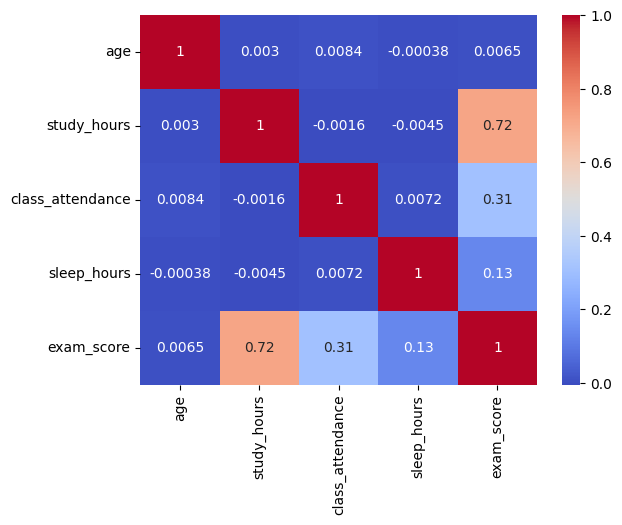

In [12]:
df = df_dados[atributos].select_dtypes(include= [np.number])

# visualizando por meio de um heatmap
plt.figure()
sns.heatmap(data = df.corr(), annot= True, cmap= 'coolwarm')
plt.show()


* Observando o gráfico de correlações, vemos que as variáveis numéricas têm pouca correlação entre si.

* Em relação a Variável Alvo (nota), a variável de maior correlação é horas de estudo, indicando que mais horas de estudo aumentaria as chances de ir bem na prova.

3 - Verificação de outliers

Como vou treinar mais de um modelo de machine learning e algum deles pode ser sensível a outlier, vale a pena procurar por eles e decidir em manter ou descartar (dependendo do caso).

In [13]:
# funções auxiliares
col_num = df_dados[atributos].select_dtypes(include=[np.number]).columns
col_cat = df_dados[atributos].select_dtypes(include=[object]).columns


age                    Axes(0.125,0.53;0.227941x0.35)
study_hours         Axes(0.398529,0.53;0.227941x0.35)
class_attendance    Axes(0.672059,0.53;0.227941x0.35)
sleep_hours            Axes(0.125,0.11;0.227941x0.35)
exam_score          Axes(0.398529,0.11;0.227941x0.35)
dtype: object

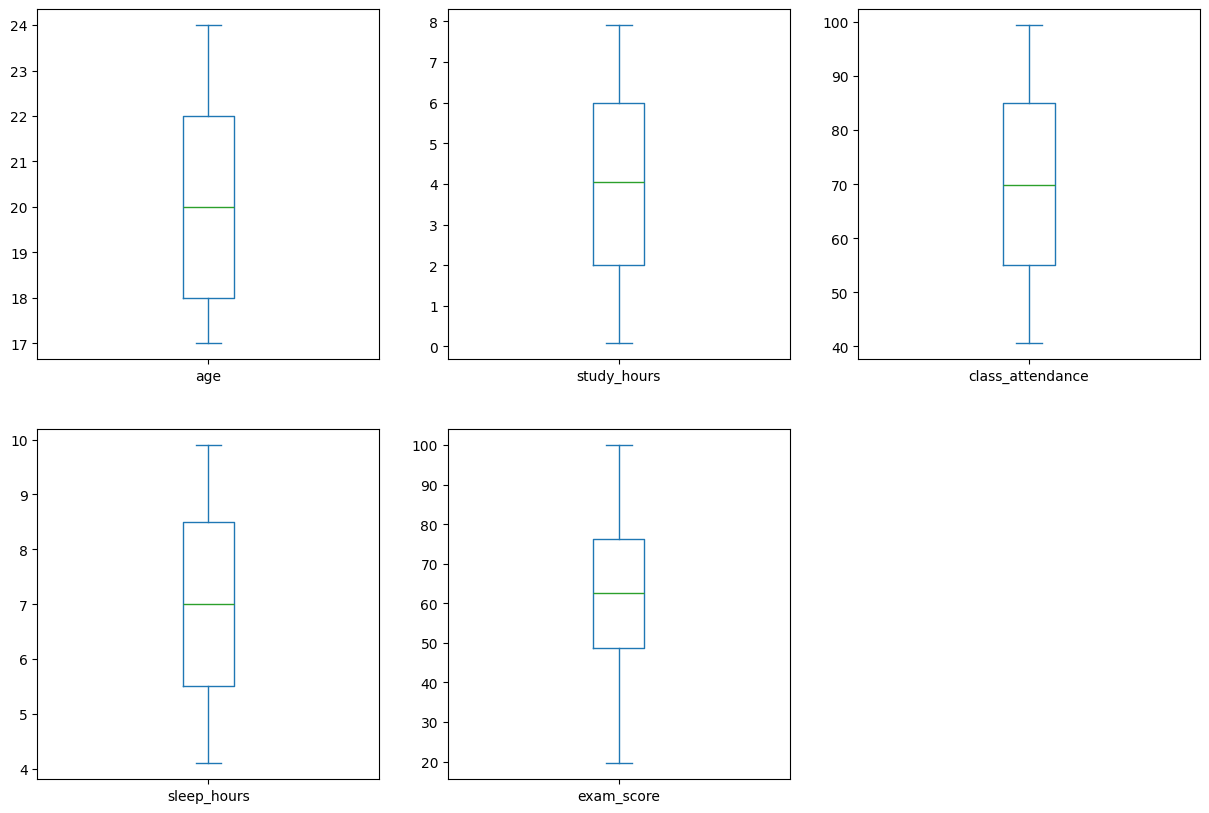

In [14]:

df_dados[col_num].plot(kind= 'box', subplots= True, sharex= False, sharey= False, layout= (2,3), figsize= (15,10))


* Análise dos boxplots

Para cada uma das variáveis numéricas, não houve outliers captados (aparentemente). Caso seja necessário, irei fazer uma análise mais aprofundada.

### será que existe outlier usando o critério básico ?

In [15]:
Q1 = df_dados[col_num].quantile(0.25)
Q3 = df_dados[col_num].quantile(0.75)

IQ = Q3 - Q1 # distância interquartílica

outliers = df_dados[(df_dados[col_num] < Q1 - 1.5 * IQ) | (df_dados[col_num] > Q3 + 1.5 * IQ)].any(axis=0)
outliers


student_id          False
age                 False
gender              False
course              False
study_hours         False
class_attendance    False
internet_access     False
sleep_hours         False
sleep_quality       False
study_method        False
facility_rating     False
exam_difficulty     False
exam_score          False
dtype: bool

nenhuma coluna, portanto, possui realmente outliers segundo o critério padrão.

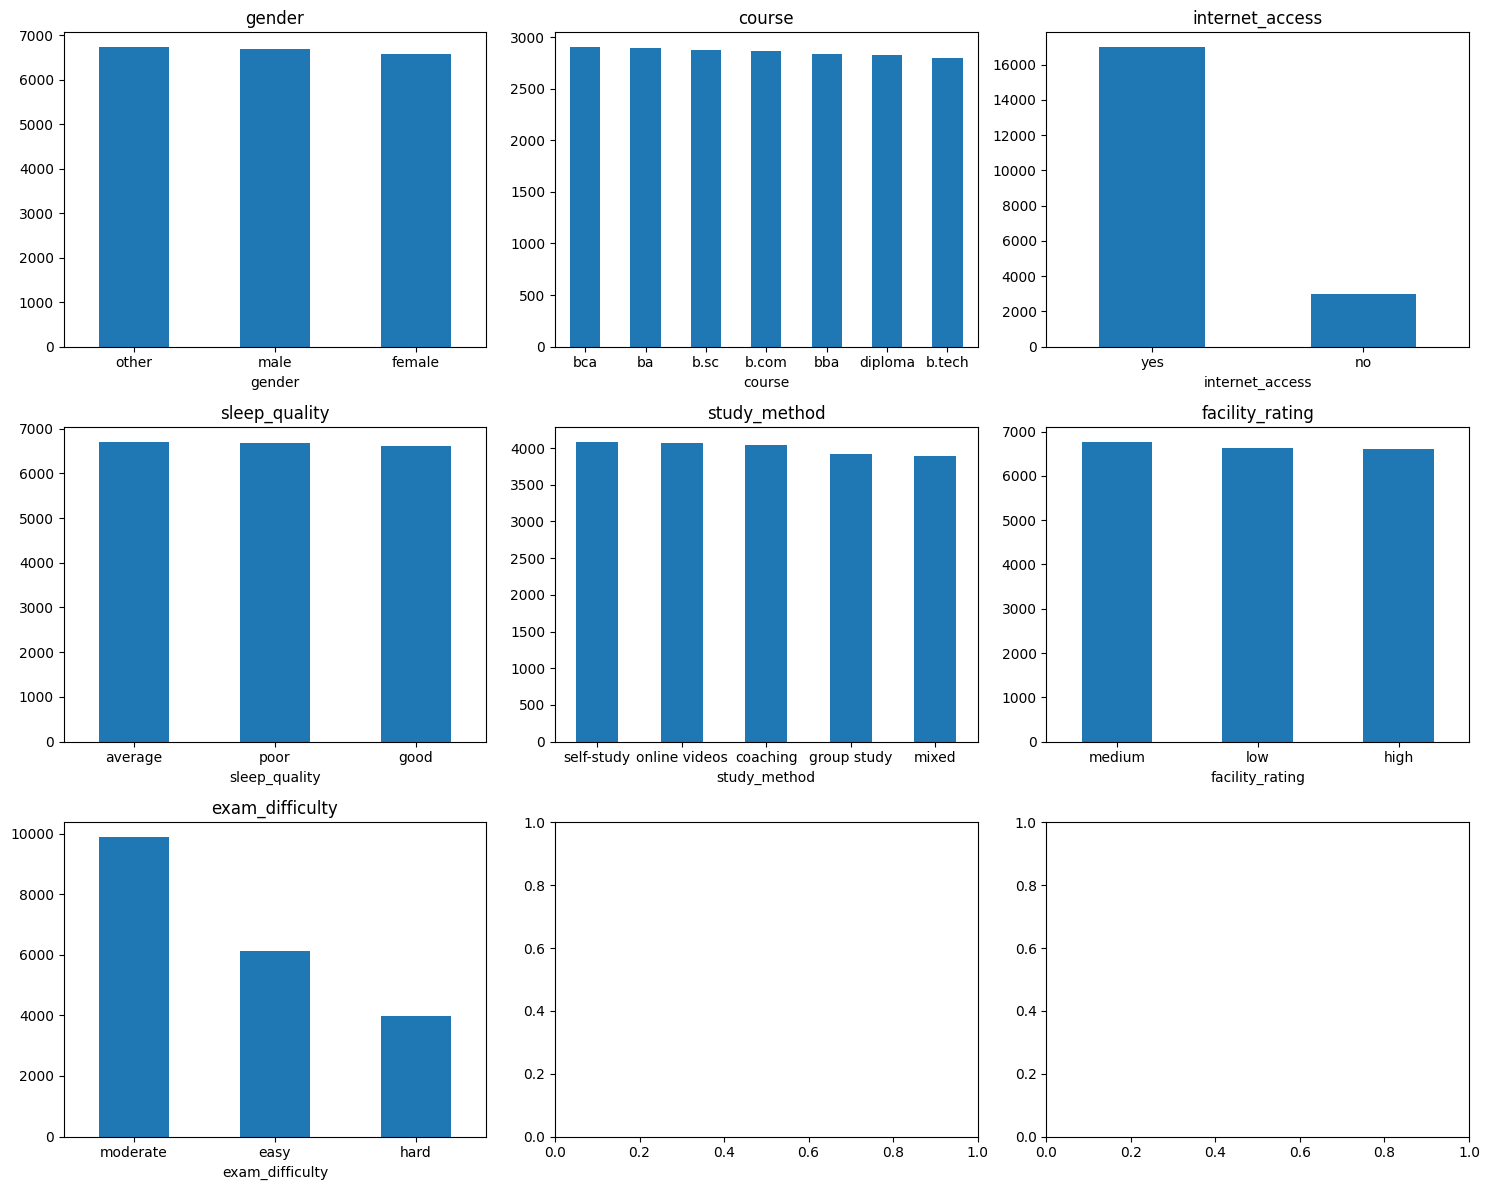

In [16]:

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(col_cat):
    # Aqui fazemos a contagem antes de plotar
    df_dados[col].value_counts().plot(kind='bar', ax=axes[i], rot= 0)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()


In [17]:
df_dados['course'].value_counts()

course
bca        2902
ba         2896
b.sc       2878
b.com      2864
bba        2836
diploma    2826
b.tech     2798
Name: count, dtype: int64

Os valores dos cursos preenchidos podem ser divididos pelas seguintes áreas : Tecnologia, Corporativo e Outros.

Isso ajudará a simplificar o modelo, pois estaremos reduzindo o número de variáveis Dummies ao final.

In [18]:
exatas = ['bca','b.tech', 'b.sc']
negocios = ['bba', 'b.com']
outros = ['ba','diploma']

df_dados.loc[df_dados['course'].isin(exatas),'course'] = 'Exatas'
df_dados.loc[df_dados['course'].isin(negocios),'course'] = 'Negocios'
df_dados.loc[df_dados['course'].isin(outros),'course'] = 'Outros'

In [19]:
df_dados['course'].value_counts()

course
Exatas      8578
Outros      5722
Negocios    5700
Name: count, dtype: int64

Observei que é possível também agrupar os diferentes métodos de estudos da seguinte forma:
* métodos com auxílio de outra pessoa
* métodos sem esse auxílio

Também irei aplicar esse agrupamento de classes a fim de simplificar o modelo.

In [20]:
df_dados['study_method'].value_counts()

study_method
self-study       4079
online videos    4069
coaching         4036
group study      3922
mixed            3894
Name: count, dtype: int64

In [21]:
auxilio = ['group study', 'coaching']
sem_auxilio = ['self-study','online videos']
df_dados.loc[df_dados['study_method'].isin(auxilio), 'study_method'] = 'Dependente'
df_dados.loc[df_dados['study_method'].isin(sem_auxilio) , 'study_method'] = 'Independente'



In [22]:
df_dados['study_method'].value_counts()

study_method
Independente    8148
Dependente      7958
mixed           3894
Name: count, dtype: int64

Das variáveis categóricas, o ponto de atenção está em acesso à internet. Isso porque quase a coluna inteira é preenchida com valor 'sim'.

 Portanto, por ser binária e  muito desbalanceada essa variável , irei seguir sem essa variável.
 

In [23]:
atributos.remove('internet_access')

In [24]:
atributos

['age',
 'gender',
 'course',
 'study_hours',
 'class_attendance',
 'sleep_hours',
 'sleep_quality',
 'study_method',
 'facility_rating',
 'exam_difficulty',
 'exam_score']

### Criação de modelos de machine Learning

Lista de modelos a serem utilizados:
* Regressão linear
* RandomForest
* Xgboost


In [25]:
modelos = {
    'Regressão Linear' : LinearRegression(),
    'RandomForestRegressor' : RandomForestRegressor(),
    'XGboost' : XGBRegressor(),
    # 'Regressão Logística': LogisticRegression()
}

In [26]:
# etapa de One hot enconding
df_dados = pd.get_dummies(data = df_dados[atributos])

In [27]:

df_dados


,age,study_hours,class_attendance,sleep_hours,exam_score,gender_female,gender_male,gender_other,course_Exatas,course_Negocios,...,sleep_quality_poor,study_method_Dependente,study_method_Independente,study_method_mixed,facility_rating_high,facility_rating_low,facility_rating_medium,exam_difficulty_easy,exam_difficulty_hard,exam_difficulty_moderate
0,17,2.78,92.9,7.4,58.9,False,True,False,False,False,...,True,True,False,False,False,True,False,False,True,False
1,23,3.37,64.8,4.6,54.8,False,False,True,True,False,...,False,False,True,False,False,False,True,False,False,True
2,22,7.88,76.8,8.5,90.3,False,True,False,True,False,...,True,True,False,False,True,False,False,False,False,True
3,20,0.67,48.4,5.8,29.7,False,False,True,False,False,...,False,False,True,False,False,True,False,False,False,True
4,20,0.89,71.6,9.8,43.7,True,False,False,False,False,...,True,True,False,False,False,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,18,6.50,71.3,5.0,86.5,False,False,True,False,True,...,False,False,True,False,False,True,False,True,False,False
19996,18,3.71,41.6,5.9,60.9,False,True,False,False,True,...,False,True,False,False,False,False,True,False,False,True
19997,19,7.88,68.2,4.6,64.5,False,False,True,False,False,...,True,True,False,False,False,True,False,True,False,False
19998,19,4.60,76.3,6.1,79.0,False,True,False,False,True,...,False,False,True,False,False,False,True,False,False,True


In [28]:
# separação em treino e teste
X = df_dados.drop(columns= ['exam_score'])
y = df_dados['exam_score']

X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size= 0.2, random_state= 42)

# Padronização
col_num = list(col_num)
col_num.remove('exam_score')
scaler = StandardScaler()
X_treino[col_num] = scaler.fit_transform(X_treino[col_num])

X_teste[col_num] = scaler.transform(X_teste[col_num])


In [29]:
for nome, modelo in modelos.items():
    # treinar e prever 
    modelo.fit(X_treino, y_treino)
    y_prev_treino = modelo.predict(X_treino)
    y_prev_teste = modelo.predict(X_teste)

    # avalia o modelo (treino)
    RMSE = root_mean_squared_error(y_treino, y_prev_treino)
    r2 = r2_score(y_treino, y_prev_treino)

    print(nome,'\n\n' )
    print('Treino :')
    print(f'R^2 : {round(r2, 2)}')
    print(f'RSME : {round(RMSE, 2)}')
    print('- ' * 15)

    # avalia o modelo (teste)
    RMSE = root_mean_squared_error(y_teste, y_prev_teste)
    r2 = r2_score(y_teste, y_prev_teste)


    print('Teste :')
    print(f'R^2 : {round(r2, 2)}')
    print(f'RSME : {round(RMSE, 2)}')
    print('- ' * 15)

    

Regressão Linear 


Treino :
R^2 : 0.72
RSME : 10.09
- - - - - - - - - - - - - - - 
Teste :
R^2 : 0.72
RSME : 10.05
- - - - - - - - - - - - - - - 
RandomForestRegressor 


Treino :
R^2 : 0.96
RSME : 3.97
- - - - - - - - - - - - - - - 
Teste :
R^2 : 0.68
RSME : 10.62
- - - - - - - - - - - - - - - 
XGboost 


Treino :
R^2 : 0.84
RSME : 7.5
- - - - - - - - - - - - - - - 
Teste :
R^2 : 0.68
RSME : 10.74
- - - - - - - - - - - - - - - 


Modelo escolhido: Regressão linear

Justificativa : Este foi o único modelo que não sofreu um overfitting severo. Os outros dois se superajustaram a base de treino e tiveram um pésssimo desempenho no teste. Já a regressão linear se manteve estável quanto ao que aprendeu quando testada para novos valores.

### Redução de Dimensionalidade

1 - Escolha do valor ideal do número de Componentes Principais

In [30]:
scores = []

for i in range(1, 23):
    pca = PCA(n_components= i)

    pca_dados = pca.fit_transform(X_treino)

    modelo = LinearRegression()

    score = cross_val_score(estimator= modelo, X = pca_dados, y = y_treino, cv= 5).mean()

    scores.append(score)



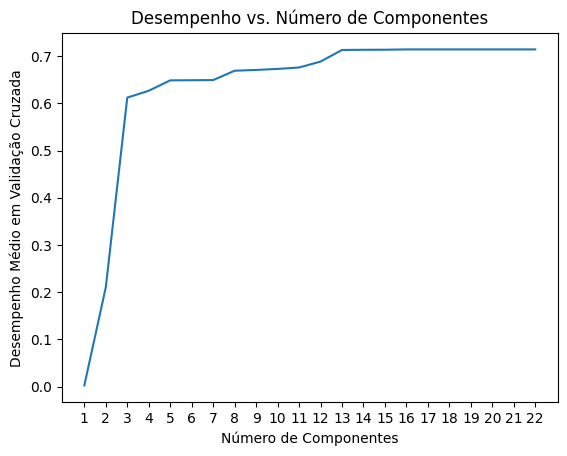

In [31]:
# Plot
plt.Figure(figsize=(10, 3))
plt.plot(range(1, 23), scores)
plt.xticks(range(1,23))
plt.xlabel('Número de Componentes')
plt.ylabel('Desempenho Médio em Validação Cruzada')
plt.title('Desempenho vs. Número de Componentes')
plt.show()

In [32]:
pca = PCA(n_components= 14)
X_treino_pca = pca_dados = pca.fit_transform(X_treino)
X_teste_pca = pca_dados = pca.transform(X_teste)

for nome, modelo in modelos.items():
    # treinar e prever 
    modelo.fit(X_treino_pca, y_treino)
    y_prev_treino = modelo.predict(X_treino_pca)
    y_prev_teste = modelo.predict(X_teste_pca)

    # avalia o modelo (treino)
    RMSE = root_mean_squared_error(y_treino, y_prev_treino)
    r2 = r2_score(y_treino, y_prev_treino)

    print(nome,'\n\n' )
    print('Treino :')
    print(f'R^2 : {round(r2, 2)}')
    print(f'RSME : {round(RMSE, 2)}')
    print('- ' * 15)

    # avalia o modelo (teste)
    RMSE = root_mean_squared_error(y_teste, y_prev_teste)
    r2 = r2_score(y_teste, y_prev_teste)


    print('Teste :')
    print(f'R^2 : {round(r2, 2)}')
    print(f'RSME : {round(RMSE, 2)}')
    print('- ' * 15)

    

Regressão Linear 


Treino :
R^2 : 0.71
RSME : 10.11
- - - - - - - - - - - - - - - 
Teste :
R^2 : 0.72
RSME : 10.08
- - - - - - - - - - - - - - - 
RandomForestRegressor 


Treino :
R^2 : 0.96
RSME : 3.97
- - - - - - - - - - - - - - - 
Teste :
R^2 : 0.69
RSME : 10.51
- - - - - - - - - - - - - - - 
XGboost 


Treino :
R^2 : 0.86
RSME : 7.07
- - - - - - - - - - - - - - - 
Teste :
R^2 : 0.68
RSME : 10.76
- - - - - - - - - - - - - - - 
